In [ ]:
import pandas as pd
import numpy as np
import os
from mygene import MyGeneInfo
from concurrent.futures import ThreadPoolExecutor
from pyensembl import EnsemblRelease
from sklearn.metrics import accuracy_score
import time
import pickle
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.random.set_seed(42)


AUGMENTATION = 0
# CANCER_TYPE = "brain"

# Specify the path to the parent directory containing the folders to iterate through
# data_geo_file_path = f"data_geo_{CANCER_TYPE}_{AUGMENTATION}.pkl"
all_data_columns_file_path = "./all_data_columns.pkl"
encoder_file = f"./encoder_{AUGMENTATION}.pkl"
model_file_name = f"nn-{AUGMENTATION}.model"

       Sample ID   Tissue
0     GSM5585901  adrenal
1     GSM5585902  bladder
2     GSM5585903  bladder
3     GSM5585904  bladder
4     GSM5585905  bladder
...          ...      ...
1055  GSM5586956  abdomen
1056  GSM5586957  abdomen
1057  GSM5586958   stroma
1058  GSM5586959     live
1059  GSM5586960      arm

[1060 rows x 2 columns]
       Tissue
0     adrenal
1     bladder
2     bladder
3     bladder
4     bladder
...       ...
1055  abdomen
1056  abdomen
1057   stroma
1058     live
1059      arm

[1060 rows x 1 columns]


In [4]:
# load label encoder from pickle file
with open(encoder_file, 'rb') as f:
    label_encoder = pickle.load(f)
class_list = label_encoder.classes_
print(class_list)

to_remove = samples_labels_2["Tissue"].map(lambda x: x in class_list)
labels_geo = samples_labels_2.loc[to_remove]
tpm_geo = df_geo_cancers.loc[to_remove]

# Get the count of samples for each unique label
label_counts = labels_geo["Tissue"].value_counts()

# Print the count of samples for each unique label
print("Label counts:")
print(label_counts)

print(labels_geo)
print(tpm_geo)

print(f'Total geo columns: {len(tpm_geo.columns)}')
print(f'Unique geo columns: {len(set(tpm_geo.columns))}')

# merging the columns with the same symbol name
data_geo = tpm_geo.groupby(tpm_geo.columns, axis=1).sum()
print(f'Total geo columns: {len(data_geo.columns)}')

unique_columns = len(set(data_geo.columns))
print(f'Unique geo columns: {unique_columns}')

['bladder' 'brain' 'breast' 'colon' 'kidney' 'liver' 'lung' 'pancreas'
 'prostate' 'skin']
Label counts:
Tissue
kidney      224
lung        112
skin         93
bladder      58
liver        28
brain        18
pancreas      7
Name: count, dtype: int64
             Tissue
GSM5585902  bladder
GSM5585903  bladder
GSM5585904  bladder
GSM5585905  bladder
GSM5585906  bladder
...             ...
GSM5586912    brain
GSM5586935    liver
GSM5586936    liver
GSM5586937    liver
GSM5586938    liver

[540 rows x 1 columns]
Symbol      DDX11L1   WASH7P  MIR6859-1  MIR1302-2HG  MIR1302-2  FAM138A   
GSM5585902   0.0000  14.2900      0.000       0.0000        0.0   0.0000  \
GSM5585903   0.0000   0.7974      0.000       0.0000        0.0   0.0000   
GSM5585904   0.7844   5.9090      0.000       0.0000        0.0   0.0000   
GSM5585905   0.5263  24.8200     10.660       0.0000        0.0   0.0000   
GSM5585906   0.0434  19.9400     24.250       0.1333        0.0   0.0000   
...             ...      ...  

In [5]:
#open the list of genes from tcga
with open(all_data_columns_file_path, 'rb') as all_data_columns_pckl:
    all_data_columns = pickle.load(all_data_columns_pckl)

In [6]:
print("length data_geo.columns: ", len(data_geo.columns))
print("length all_data_columns: ", len(all_data_columns))

# Delete all columns from data_geo dataframe that are not present in all_data_columns list
columns_to_drop = [col for col in data_geo.columns if col not in all_data_columns]
print("length columns_to_drop: ", len(columns_to_drop))

data_geo_filtered = data_geo.drop(columns=columns_to_drop)
print("data_geo_filtered shape: " , data_geo_filtered.shape)
      
# For each column name in all_data_columns list add a column of zeros to data_geo_filtered dataframe 
# if the column with that name does not exist, otherwise ignore it

# Create a DataFrame with zeros for missing columns
zeros_df = pd.DataFrame(0, index=data_geo_filtered.index, columns=all_data_columns)

# Concatenate data_geo_filtered and zeros_df
data_geo_filtered = pd.concat([data_geo_filtered, zeros_df], axis=1)

# Remove duplicate columns
data_geo_filtered = data_geo_filtered.loc[:, ~data_geo_filtered.columns.duplicated()]


# Construct validation dataset with proper column ordering defined in all_data_columns
data_geo_test = data_geo_filtered[all_data_columns]
print("data_geo_test shape: ", data_geo_test.shape)

length data_geo.columns:  39374
length all_data_columns:  59427
length columns_to_drop:  12302
data_geo_filtered shape:  (540, 27072)
data_geo_test shape:  (540, 59427)


# Validate data geo on trained tcga classifier

In [7]:
# load the nn model
with open(model_file_name, 'rb') as f:
    model = pickle.load(f)

2023-06-17 18:12:41.727776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-17 18:12:41.751932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-17 18:12:41.752170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [35]:
# encoding the test data with the same label encoder used in training
all_labels_encoded = label_encoder.transform(labels_geo)
print(labels_geo.tail(5))
# print(all_labels_encoded)

# sort the data_geo_test columns
# data_geo_test = data_geo_test[all_data_columns]
print(data_geo_test.tail(5))

           Tissue
GSM5586912  brain
GSM5586935  liver
GSM5586936  liver
GSM5586937  liver
GSM5586938  liver
            SLAIN2  AC108120.2  KIAA0232  SMYD3-IT1  AC009234.1  RNA5SP172   
GSM5586912   20.35           0    26.970          0           0          0  \
GSM5586935   20.94           0    17.810          0           0          0   
GSM5586936   16.85           0    14.600          0           0          0   
GSM5586937   13.86           0    17.740          0           0          0   
GSM5586938   45.19           0     7.635          0           0          0   

            AC011005.1  AC007099.3   MAST1  AC027796.3  ...  IGHVIII-25-1   
GSM5586912           0           0  3.0920           0  ...           0.0  \
GSM5586935           0           0  0.5148           0  ...           0.0   
GSM5586936           0           0  0.0000           0  ...           0.0   
GSM5586937           0           0  0.0000           0  ...           0.0   
GSM5586938           0           0  0.

/home/rubi/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9

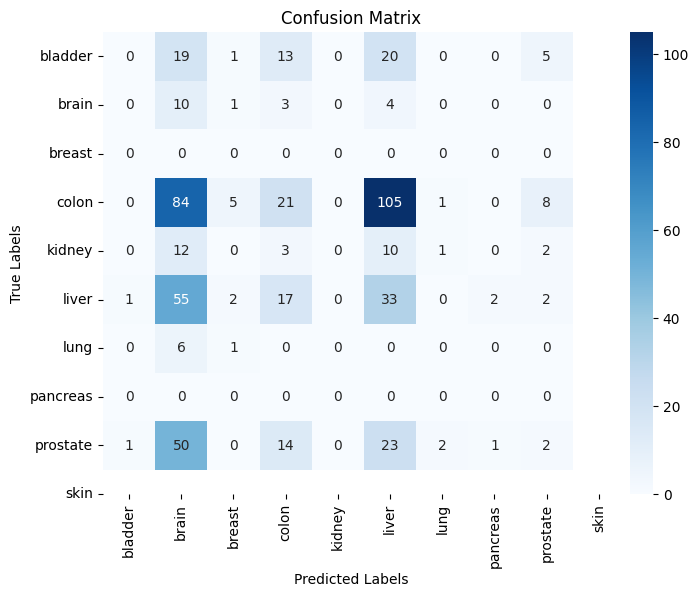

In [36]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
tf.random.set_seed(42)

# Assuming `test_labels` contains the true class labels for the test set
test_labels = tf.convert_to_tensor(all_labels_encoded, tf.int32)
print(test_labels)

# Assuming the model is already trained and stored the predictions in `test_predictions`
test_data_evaluated = tf.convert_to_tensor(data_geo_test, tf.float64)
print(test_data_evaluated.shape)
test_predictions = model.predict(test_data_evaluated)
print(test_predictions)
test_predictions = np.argmax(test_predictions, axis=1)
print(test_predictions)
# print(test_predictions)

accuracy = sum(test_predictions == all_labels_encoded) / float(len(test_predictions))
print("Accuracy of the test: %.4f%%" % (accuracy * 100.0))

# Assuming `label_encoder` contains the label encoder used during training
label_names = label_encoder.classes_
confusion_mat = confusion_matrix(test_labels, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# print("Verifying accuracy...")
# # verify accuracy of the test data
# pred_test = model.predict(data_geo_test)

# accuracy = sum(pred_test == all_labels_encoded) / float(len(pred_test))

# print("Accuracy of the test: %.4f%%" % (accuracy * 100.0))

# print(label_encoder.classes_)
# confusion = sklearn.metrics.confusion_matrix(all_labels_encoded, pred_test)
# print(confusion)

# # Plotting the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
#             xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already calculated the confusion matrix
confusion = confusion_matrix(all_labels_encoded, test_predictions)

# Calculate precision
precision = precision_score(all_labels_encoded, test_predictions, average='macro')

# Calculate recall
recall = recall_score(all_labels_encoded, test_predictions, average='macro')

# Calculate F1 score
f1 = f1_score(all_labels_encoded, test_predictions, average='macro')

# Print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


Precision: 0.3104
Recall: 0.1330
F1 Score: 0.1180


/home/rubi/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
